In [8]:
import numpy as np
#from scipy import stats
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.colors import LogNorm

from functools import partial
from scarlet.display import AsinhMapping
#from photutils.psf import extract_stars
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling import rotations
#from photutils import EPSFBuilder
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping
import sep
from functools import partial
import image_registration
import pandas as pd
import pandasql as ps
from matplotlib.colors import LogNorm

from scipy.ndimage.interpolation import rotate
from astropy.wcs import WCS

In [9]:
channels = ['u','g','r','i','z']

In [10]:
def makeCatalog(img, lvl = 3):
    print(np.size(img.shape))
    if np.size(img.shape) == 3:
        detect = img.mean(axis=0) # simple average for detection
    else:
        detect = img

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    if np.size(img.shape) == 3:
        bg_rms = np.array([sep.Background(band).globalrms for band in img])
    else:
        bg_rms =  sep.Background(detect).globalrms
    return catalog, bg_rms

In [11]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
    alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    for image in range(1,len(hdulist)):
        im1 = hdulist[image]
        yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
        im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
        alignedHDU.append(im1_aligned_to_im2)

    return alignedHDU


In [69]:
def alignImages(hdulist):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
#     alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    im1 = hdulist[1]
    yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
    im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
    alignedHDU = im1_aligned_to_im2

    return alignedHDU

In [70]:
def maskAlign(hdulist,mask):
#     shaperoni = im1_aligned_to_im2.shape
#     xsegments = int(shaperoni[0]/100)
#     ylen = shaperoni[0] 
#     alignedHDU = [hdulist[0]]
    im2 = hdulist[0]
    im1 = hdulist[1]
    yoff,xoff = image_registration.cross_correlation_shifts(im1,im2)
    im1_aligned_to_im2 = np.roll(np.roll(mask,int(yoff),1),int(xoff),0)
    alignedHDU = im1_aligned_to_im2

    return alignedHDU

In [32]:
# def maskAlign(mask,offsets):
#     print(offsets)
#     offsets = offsets[0]
#     im1 = mask
#     yoff,xoff = offsets[0],offsets[1]
#     im1_aligned_to_im2 = np.roll(np.roll(im1,int(yoff),1),int(xoff),0)
#     alignedHDU = im1_aligned_to_im2

#     return alignedHDU

In [14]:
def AlignOnly(imageName,refImageName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    #BG = sep.Background(data).globalback
    
    if matchLimits != 'None': # used to crop images to the same size
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    aligned = alignImages([refData,data])
    alignedData = aligned[1]
    data = alignedData
     
    return data

In [15]:
# for x in range(len(channels)):
#     aligned = AlignOnly(images[x],images[0],imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
#     #plt.imshow(aligned)
#     aData = fits.PrimaryHDU(aligned)
#     hdur = fits.HDUList([aData])
#     hdur.writeto('/home/mj1e16/scarlet/scarlet/data/globularCluster/Algined{}.fits'.format(channels[x]))

In [71]:
def makeImageData(imageName,psfName,filterName,refImageName,maskImageName,refMaskName,imageLimits='None',matchLimits='None'): # imageLimits = [miny,maxy,minx,maxx]
    image = fits.open(imageName)
    data = image[0].data.byteswap().newbyteorder()
    BG = sep.Background(data).globalback
    
    refImage = fits.open(refImageName)
    refData = refImage[0].data.byteswap().newbyteorder()
    
    imdata =  fits.open(maskImageName)
    imdat = imdata[0].data.byteswap().newbyteorder()
    rotated = rotate(imdat,90,axes=(1,0))
    rotated = np.flip(rotated,axis=1)
    
    refmaskdata = fits.open(refMaskName)
    refdata = refmaskdata[0].data.byteswap().newbyteorder()
    rotatedRef = rotate(refdata,90,axes=(1,0))
    rotatedRef = np.flip(rotatedRef,axis=1)
    
    if matchLimits != 'None': # used to crop images to the same size so alignment will function
        data = data[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        refData = refData[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        rotated = rotated[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        rotatedRef = rotatedRef[matchLimits[2]:matchLimits[3],matchLimits[0]:matchLimits[1]]
        
    print('data Shape',data.shape)
    print('refdata Shape',refData.shape)

    data = alignImages([refData,data])
    
    alignedMask = maskAlign([refData,rotatedRef],rotated)
        
    if imageLimits != 'None': # cropping image to seleted patch
        data = data[imageLimits[2]:imageLimits[3],imageLimits[0]:imageLimits[1]]
        maskData = alignedMask[imageLimits[2]:imageLimits[3],imageLimits[0]:imageLimits[1]]
        
    print(data.shape)
    print(imageLimits[0],imageLimits[1])
    wcs = WCS(image[0].header)
    data_BS = data - BG #?
    catalogue, bg_rms = makeCatalog(data_BS)
    weights = maskData
    psf = fits.open(psfName)[0].data
    
    ### testing PSF backgorunds
    psf_data = psf.byteswap().newbyteorder()
    psf = psf_data
#     BG_PSF = sep.Background(psf_data)
#     psf_BS = psf_data - BG_PSF
#     psf = psf_BS
    
    #psf = psf[None,:,:]
#    psf = scarlet.PSF(psf)
    return {'data':data_BS,'wcs':wcs,'backgorund':BG,'catalogue':catalogue,'weights':weights,'psf':psf,'filter':filterName}

In [72]:
def matchTables(array1,array2,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x < pandasTable2.xUpper
    AND pandasTable1.x > pandasTable2.xLower
    AND pandasTable1.y < pandasTable2.yUpper
    AND pandasTable1.y > pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [73]:
def matchTablesAllFilters(arrayList,tollerance=5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x < pandasTable2.xUpper
    AND pandasTable1.x > pandasTable2.xLower
    AND pandasTable1.y < pandasTable2.yUpper
    AND pandasTable1.y > pandasTable2.yLower
    '''
    channels = ['u','g','r','i','z']
    dictList = []
    for x in range(1,len(arrayList)):
        dictList.append({'indexOG':range(len(arrayList[x])),'x':arrayList[x]['x'],'y':arrayList[x]['y'],'flux_{}'.format(channels[x]):arrayList[x]['flux']})

        
    xcoord = arrayList[0]['x']
    ycoord = arrayList[0]['y']
    flux = arrayList[0]['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'flux_u':flux}
    
    for x in range(len(dictList)):
        if x == 0:
            pandasTable2 = pd.DataFrame(data=refDict)
            pandasTable1 = pd.DataFrame(data=dictList[x])
            newdf = ps.sqldf(sqlcode,locals())
        else:
            pandasTable1 = pd.DataFrame(data=dictList[x])
            pandasTable2 = newdf
            newdf = ps.sqldf(sqlcode,locals())
    #print(pandasTable1['xcentroid'])
    
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [74]:
def antiMatchTables(array1,array2,tollerance=2.5):
    sqlcode = '''
    SELECT *
    FROM pandasTable1
    JOIN pandasTable2
    ON pandasTable1.x > pandasTable2.xUpper
    AND pandasTable1.x < pandasTable2.xLower
    AND pandasTable1.y > pandasTable2.yUpper
    AND pandasTable1.y < pandasTable2.yLower
    '''
    
    ogDict = {'indexOG':range(len(array1)),'x':array1['x'],'y':array1['y']}
    pandasTable1 = pd.DataFrame(data=ogDict)
    
    xcoord = array2['x']
    ycoord = array2['y']
    flux = array2['flux']
    
    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]
    

    refDict = {'indexMatch':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower,'fluxMatch':flux}
    pandasTable2 = pd.DataFrame(data=refDict)
    #print(pandasTable1['xcentroid'])
    newdf = ps.sqldf(sqlcode,locals())
    
    return newdf

In [75]:
images = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_041112_u_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040903_g_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_035740_r_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040445_i_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/c4d_130511_040655_z_50.fits']
  

psfImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/u_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/g_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/r_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/i_psf_peak_normalized.fits',
            '/home/mj1e16/scarlet/scarlet/data/globularCluster/PSFSNEW/NEW_PSFs/z_psf_peak_normalized.fits']

masks = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_u_ood.fits',
        '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_g_ood.fits',
        '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_r_ood.fits',
        '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_i_ood.fits',
        '/home/mj1e16/scarlet/scarlet/data/globularCluster/MASKS/glob_z_ood.fits'] # extracted from full masks

maskImages = ['/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_041112_oow_u_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040903_oow_g_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_035740_oow_r_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040445_oow_i_v1_50.fits',
         '/home/mj1e16/scarlet/scarlet/data/globularCluster/alignedImages/c4d_130511_040655_oow_z_v1_50.fits'] # images aligned to masks

# masks and images are perfectly aligned, ever so slight misaignment accross images

channels = ['u','g','r','i','z']

miny = 1000
maxy = 1500

minx = 200
maxx = 700

# miny = 1050
# maxy = 1100

# maxx = 400
# minx = 350


refImage = images[0]

for x in range(len(channels)):
    Data = makeImageData(images[x],psfImages[x],channels[x],refImage,masks[x],maskImages[x],imageLimits=[minx,maxx,miny,maxy],matchLimits=[0,3970,0,1980])
    if x ==  0:
        imageList, catalogueList, weigthsList, psfList = [Data['data']], Data['catalogue'], [Data['weights']], [Data['psf']]
        catList = [Data['catalogue']]
        print(Data['data'].shape)
        print(psfList[x].shape)
        print('clog',len(catalogueList))
    else:
        print(Data['data'].shape)
        imageList = np.append(imageList,[Data['data']],axis=0)
        catList.append(Data['catalogue'])
        catalogueList = np.concatenate((catalogueList,Data['catalogue']),axis=0)
        print('clog',len(catalogueList))
        weigthsList = np.append(weigthsList,[Data['weights']],axis=0)
        psfList = np.append(psfList,[Data['psf']],axis=0)

data Shape (1980, 3970)
refdata Shape (1980, 3970)


/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
/home/mj1e16/miniconda2/envs/scarletCC/lib/python3.5/site-packages/image_registration/fft_tools/convolve_nd.py:325: FutureWarning: Using a non-tuple sequence f

(500, 500)
200 700
2
(500, 500)
(41, 41)
clog 194


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


data Shape (1980, 3970)
refdata Shape (1980, 3970)
(500, 500)
200 700
2
(500, 500)
clog 413
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(500, 500)
200 700
2
(500, 500)
clog 654
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(500, 500)
200 700
2
(500, 500)
clog 933
data Shape (1980, 3970)
refdata Shape (1980, 3970)
(500, 500)
200 700
2
(500, 500)
clog 1228


In [76]:
psfs=scarlet.PSF(psfList)

In [77]:
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=0.9), shape=(None,101,101))

In [78]:
model_frame = scarlet.Frame(imageList.shape,
                          psfs=model_psf,
                          channels=channels)


In [79]:
observation = scarlet.Observation(
    imageList,
    psfs=psfs,
    weights=weigthsList,
    channels=channels).match(model_frame)


In [80]:
# for x in range(len(catalogueList)):
#     if x ==0:
#         matchDF = catalogueList
#     else:
#         matchDF = matchTables(matchDF,catalogueList[x])

In [81]:
# matchArray = matchDF.to_records(index=False)

In [82]:
sources = []

for k,src in enumerate(catalogueList):
    #print(k)
    sources.append(scarlet.PointSource(model_frame,(src['y'],src['x']),observation))

In [59]:
sources = []

for k,src in enumerate(catalogueList):
    #print(k)
    sources.append(scarlet.ExtendedSource(model_frame,(src['y'],src['x']),observation))

In [60]:
# sources = []

# for k,src in enumerate(catofMatches):
#     print(k)
#     sources.append(scarlet.ExtendedSource(model_frame,(src[1],src[0]),observation))

In [83]:
norm =  AsinhMapping(minimum=0, stretch=0.1, Q=100)

In [84]:
from matplotlib.colors import LogNorm

([], <a list of 0 Text xticklabel objects>)

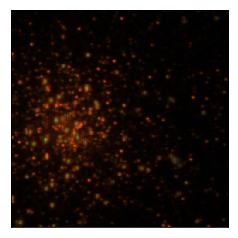

In [85]:
from scarlet.display import AsinhMapping

stretch = 0.2
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(imageList)
plt.imshow(img_rgb,norm=LogNorm())
plt.yticks([])
plt.xticks([])
# Mark all of the sources from the detection cataog
# for k, src in enumerate(catalogueList[0]):
#     plt.text(src["x"], src["y"], str(k), color="red")



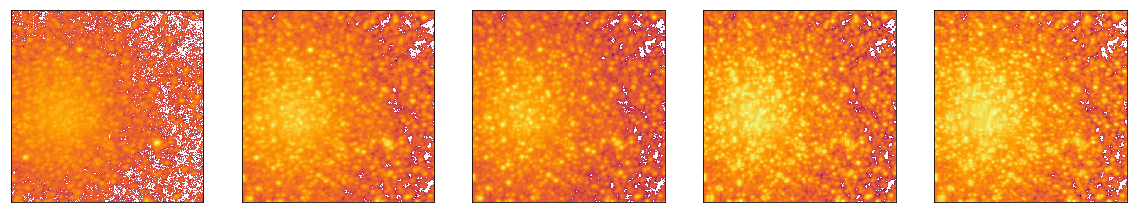

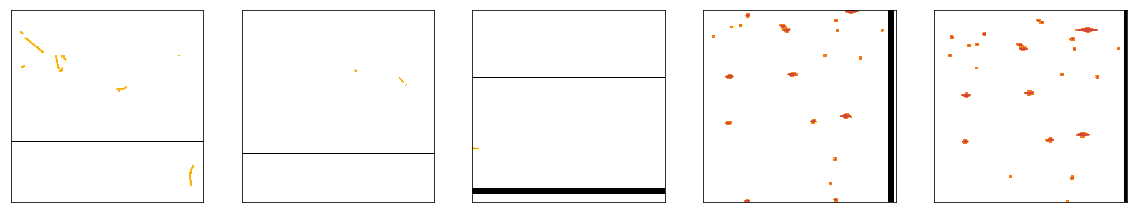

In [86]:
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i,x in enumerate(imageList):
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])
    
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i,x in enumerate(weigthsList):
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])
#     hdu = fits.PrimaryHDU(x)
#     hdul = fits.HDUList([hdu])
#     hdu.writeto('NGC_6569_cutout_{}.fits'.format(channels[i]))

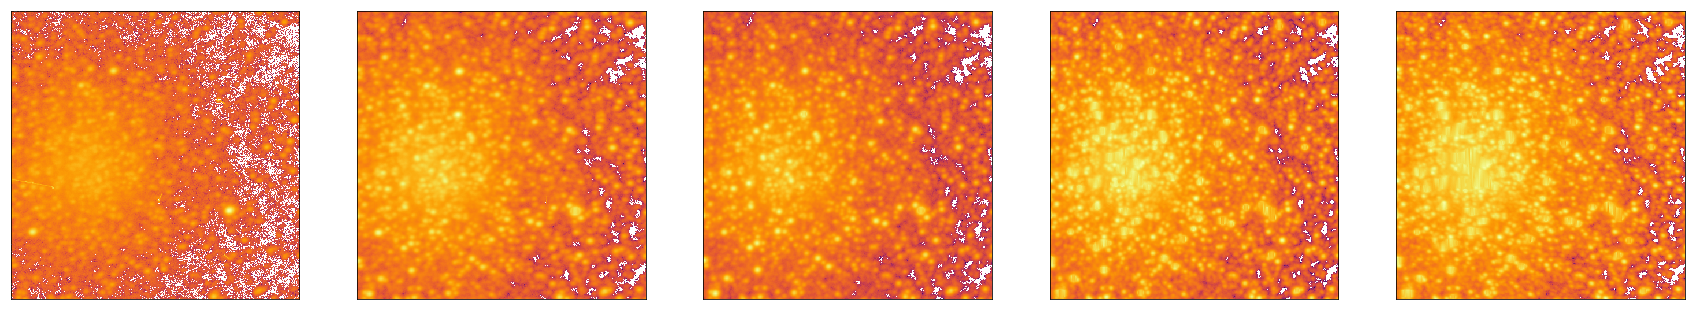

In [87]:
fig, ax = plt.subplots(1,5,figsize=(30,10))
for i,x in enumerate(imageList):

    
    myInterval=500.
    loc = plticker.MultipleLocator(base=myInterval)
    ax[i].xaxis.set_major_locator(loc)
    ax[i].yaxis.set_major_locator(loc)

# Add the grid
    ax[i].grid(which='major', axis='both', linestyle='-')
    
    ax[i].imshow(x,norm=LogNorm())
    ax[i].set_yticks([])
    ax[i].set_xticks([])
fig.savefig('myImageGrid.png',dpi=100)
#     hdu = fits.PrimaryHDU(x)
#     hdul = fits.HDUList([hdu])
#     hdu.writeto('NGC_6569_cutout_{}.fits'.format(channels[i]))

KeyboardInterrupt: 

scarlet ran for 12 iterations to logL = -126392512271.02547


Text(0,0.5,'log-Likelihood')

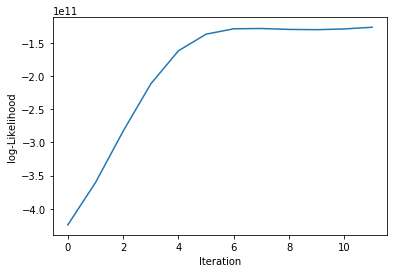

In [88]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

In [89]:
model = blend.get_model()
model_ = observation.render(model)
residual = imageList-model_

# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual



KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

# for k,component in enumerate(blend):
#     y,x = component.center
#     ax[0].text(x, y, k, color="w")
#     ax[1].text(x, y, k, color="w")
#     ax[2].text(x, y, k, color="w")
#plt.show()

In [68]:
scarlet.display.show_sources(sources,
                             norm=norm,
                             observation=observation)#,
#                              show_rendered=True,
#                              show_observed=True)
#plt.show()


ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

ValueError: 3-dimensional arrays must be of dtype unsigned byte, unsigned short, float32 or float64

In [ ]:
areas = [c._parameters[1]._data.shape[0] * c._parameters[1].shape[1] for c in blend.components]
plt.hist(areas)
plt.ylabel('Number of Sources')
plt.xlabel('Size')
plt.savefig('histogramOfSourcesEO.pdf',dpi=100)

In [199]:
print ("----------------- {}".format(channels))
fluxes = []
centroid = []
for k, src in enumerate(sources):
    fluxes.append(scarlet.measure.flux(src).tolist())
    centroid.append(scarlet.measure.centroid(src))
    #print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(src)))

----------------- ['u', 'g', 'r', 'i', 'z']


In [200]:
len(centroid)

28

In [201]:
fluxesNoZero = [x for x in fluxes if 0.0 not in x]
fluxesNoZero = [x for x in fluxes] # if 0.0 not in x]

print(len(fluxesNoZero))


28


In [202]:
def createMag(flux,zpMag):
    mag = (-2.5*np.log10(flux)) + zpMag
    return mag

In [203]:
Magnitudes = createMag(fluxesNoZero,29.41)

/home/mj1e16/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [204]:
u = Magnitudes[:,0]

In [205]:
r = Magnitudes[:,2]
g = Magnitudes[:,1]

In [206]:
gMinusR = g-r

/home/mj1e16/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


Text(0.5,0,'g - r')

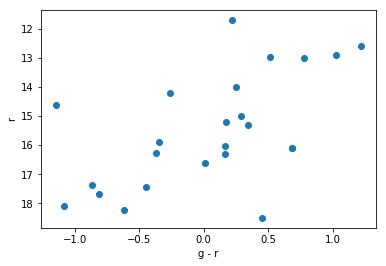

In [207]:
plt.plot(gMinusR,r,'o')
#plt.gca().invert_y_axis()
plt.gca().invert_yaxis()
plt.ylabel('r')
plt.xlabel('g - r')

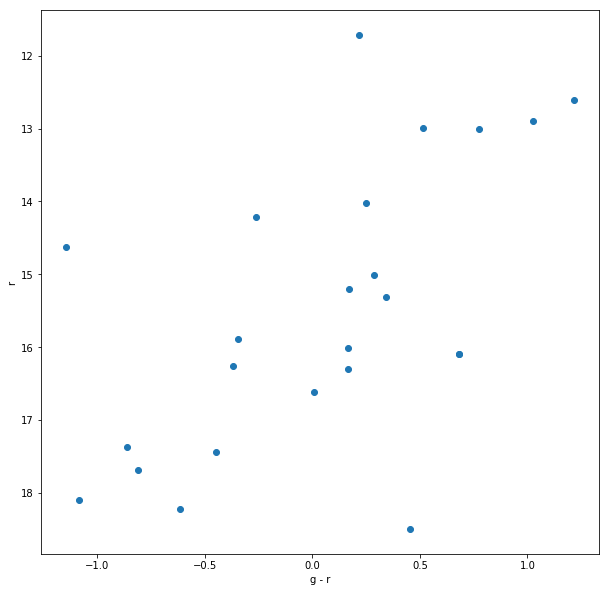

In [208]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(gMinusR,r,'o')
fig.gca().invert_yaxis()
ax.set_ylabel('r')
ax.set_xlabel('g - r')
fig.savefig('./CMDglob.pdf',dpi=100)

In [209]:
len(catalogueList)

301

In [210]:
len(sources)

28

In [211]:
df = matchTablesAllFilters(catList)
xcoords = df['xcoord'].tolist()
ycoords = df['ycoord'].tolist()

In [212]:
scarMags =  [Magnitudes[:,0], Magnitudes[:,1], Magnitudes[:,2], Magnitudes[:,3], Magnitudes[:,4]]

In [213]:
sepMags = [createMag(df['flux_u'].tolist(),29.41), createMag(df['flux_g'].tolist(),29.41), createMag(df['flux_r'].tolist(),29.41), createMag(df['flux_i'].tolist(),29.41), createMag(df['flux_z'].tolist(),29.41)]

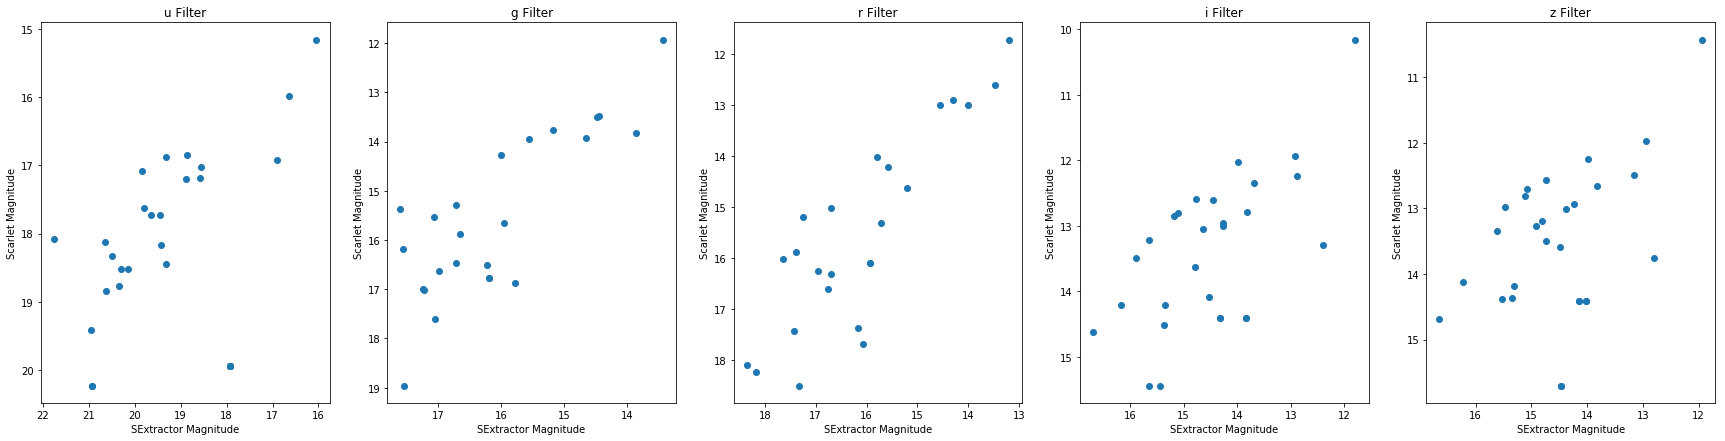

In [214]:
fig, ax  = plt.subplots(1,5,figsize=(30,7))
for x in range(len(scarMags)):
    ax[x].plot(sepMags[x],scarMags[x],'o')
    ax[x].set_xlabel('SExtractor Magnitude')
    ax[x].set_ylabel('Scarlet Magnitude')
    ax[x].set_title('{} Filter'.format(channels[x]))
    ax[x].invert_yaxis()
    ax[x].invert_xaxis()


# plt.plot(SepU,ScarU,'o')
# plt.xlabel('SExtractor Magnitude')
# plt.ylabel('Scarlet Magnitude')
# plt.title('U Filter')
plt.savefig('SextractorVSScarletMag.pdf',dpi=100)

In [ ]:
scarletDicts = {'x_scarlet':centroid[1],'y':centroid[2],'flux_scarlet'}

In [68]:
catalog

array([(14., 33.), (31., 36.), (19., 47.), (25., 15.), (37., 51.),
       (22., 23.), (34.,  5.)], dtype=[('x', '<f8'), ('y', '<f8')])

In [127]:
import pickle

In [161]:
fp = open('NGC_6569_Scarlet_sources_preblend.sca','wb')
pickle.dump(sources,fp)
fp.close()

fp = open('NGC_6569_Scarlet_sources_postblend.sca','wb')
pickle.dump(df_tofred,fp)
fp.close() 

In [164]:
fp = open('NGC_6569_Scarlet_sources_postblend.sca','rb')
df_from_pickle = pickle.load(fp)
fp.close()


In [165]:
df_from_pickle

,flux_z,flux_i,flux_r,flux_g,flux_u,xcoord,ycoord
0,4.232251e+05,4.160265e+05,6.827723e+04,5.626127e+04,2435.000000,152.662831,4.091668
1,3.583790e+05,8.992861e+05,4.804089e+05,9.742121e+05,129194.664062,37.461067,15.743244
2,5.397922e+05,4.933184e+05,7.259077e+04,5.325088e+04,1158.069092,193.005111,19.181062
3,3.750115e+05,3.205295e+05,5.087068e+04,5.490328e+04,3730.635254,91.379558,21.523882
4,6.219064e+05,9.685306e+05,2.813020e+05,2.309104e+05,8077.854980,141.932936,16.612918
5,9.368819e+05,1.936865e+06,3.025983e+05,2.433472e+05,4404.959961,118.811705,35.936280
6,1.714838e+06,1.729825e+06,8.794670e+05,4.980367e+05,3227.903564,151.878882,34.929167
7,1.876934e+05,1.996085e+05,3.114217e+04,8.795518e+04,4235.736816,50.666653,44.885592
8,1.176248e+06,1.142379e+06,1.963940e+05,1.882663e+05,9768.699219,175.302610,43.895358
9,9.504808e+05,3.204884e+05,2.453631e+05,1.950232e+05,2477.542725,1.788964,44.268095


In [ ]:
fp = open('NGC_6569_Scarlet_model.sca','wb')
pickle.dump(model_,fp)
fp.close()

In [140]:
fp = open('NGC_6569_Scarlet_model.sca','wb')
pickle.dump(model_,fp)
fp.close()

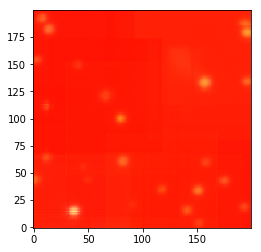

In [142]:
fp = open("NGC_6569_Scarlet_model.sca", "rb")
saveModel = pickle.load(fp)
fp.close()
model_rgb = scarlet.display.img_to_rgb(saveModel, norm=norm)
plt.imshow(model_rgb)
#scarlet.display.show_scene(sources_, norm=norm)

In [145]:
len(catList)

5

In [146]:
df

,flux_z,indexOG,x,y,flux_i,indexOG,x,y,flux_r,flux_g,flux_u,indexMatch,xLower,xUpper,xcoord,yLower,yUpper,ycoord
0,4.232251e+05,1,151.830461,3.541897,4.160265e+05,1,152.053349,2.995498,6.827723e+04,5.626127e+04,2435.000000,0,147.662831,157.662831,152.662831,-0.908332,9.091668,4.091668
1,3.583790e+05,6,36.137026,14.586202,8.992861e+05,6,37.115169,14.507620,4.804089e+05,9.742121e+05,129194.664062,4,32.461067,42.461067,37.461067,10.743244,20.743244,15.743244
2,5.397922e+05,7,192.095420,17.297574,4.933184e+05,5,192.481295,16.991184,7.259077e+04,5.325088e+04,1158.069092,3,188.005111,198.005111,193.005111,14.181062,24.181062,19.181062
3,3.750115e+05,8,90.258804,21.419027,3.205295e+05,9,90.974417,20.524494,5.087068e+04,5.490328e+04,3730.635254,5,86.379558,96.379558,91.379558,16.523882,26.523882,21.523882
4,6.219064e+05,10,140.491966,15.686294,9.685306e+05,7,140.884229,15.572350,2.813020e+05,2.309104e+05,8077.854980,2,136.932936,146.932936,141.932936,11.612918,21.612918,16.612918
5,9.368819e+05,16,117.408364,35.235280,1.936865e+06,11,119.748059,34.943659,3.025983e+05,2.433472e+05,4404.959961,7,113.811705,123.811705,118.811705,30.936280,40.936280,35.936280
6,1.714838e+06,18,150.562070,34.220512,1.729825e+06,12,149.889659,33.375388,8.794670e+05,4.980367e+05,3227.903564,6,146.878882,156.878882,151.878882,29.929167,39.929167,34.929167
7,1.876934e+05,20,54.635012,41.064091,1.996085e+05,14,52.886830,42.223759,3.114217e+04,8.795518e+04,4235.736816,10,45.666653,55.666653,50.666653,39.885592,49.885592,44.885592
8,1.176248e+06,22,172.040963,43.730089,1.142379e+06,15,173.209885,43.017712,1.963940e+05,1.882663e+05,9768.699219,11,170.302610,180.302610,175.302610,38.895358,48.895358,43.895358
9,9.504808e+05,25,3.523290,44.629658,3.204884e+05,17,3.008369,44.110533,2.453631e+05,1.950232e+05,2477.542725,9,-3.211036,6.788964,1.788964,39.268095,49.268095,44.268095


In [154]:
df_to_fred = df

In [156]:
df_to_fred

,flux_z,indexOG,x,y,flux_i,indexOG,x,y,flux_r,flux_g,flux_u,indexMatch,xLower,xUpper,xcoord,yLower,yUpper,ycoord
0,4.232251e+05,1,151.830461,3.541897,4.160265e+05,1,152.053349,2.995498,6.827723e+04,5.626127e+04,2435.000000,0,147.662831,157.662831,152.662831,-0.908332,9.091668,4.091668
1,3.583790e+05,6,36.137026,14.586202,8.992861e+05,6,37.115169,14.507620,4.804089e+05,9.742121e+05,129194.664062,4,32.461067,42.461067,37.461067,10.743244,20.743244,15.743244
2,5.397922e+05,7,192.095420,17.297574,4.933184e+05,5,192.481295,16.991184,7.259077e+04,5.325088e+04,1158.069092,3,188.005111,198.005111,193.005111,14.181062,24.181062,19.181062
3,3.750115e+05,8,90.258804,21.419027,3.205295e+05,9,90.974417,20.524494,5.087068e+04,5.490328e+04,3730.635254,5,86.379558,96.379558,91.379558,16.523882,26.523882,21.523882
4,6.219064e+05,10,140.491966,15.686294,9.685306e+05,7,140.884229,15.572350,2.813020e+05,2.309104e+05,8077.854980,2,136.932936,146.932936,141.932936,11.612918,21.612918,16.612918
5,9.368819e+05,16,117.408364,35.235280,1.936865e+06,11,119.748059,34.943659,3.025983e+05,2.433472e+05,4404.959961,7,113.811705,123.811705,118.811705,30.936280,40.936280,35.936280
6,1.714838e+06,18,150.562070,34.220512,1.729825e+06,12,149.889659,33.375388,8.794670e+05,4.980367e+05,3227.903564,6,146.878882,156.878882,151.878882,29.929167,39.929167,34.929167
7,1.876934e+05,20,54.635012,41.064091,1.996085e+05,14,52.886830,42.223759,3.114217e+04,8.795518e+04,4235.736816,10,45.666653,55.666653,50.666653,39.885592,49.885592,44.885592
8,1.176248e+06,22,172.040963,43.730089,1.142379e+06,15,173.209885,43.017712,1.963940e+05,1.882663e+05,9768.699219,11,170.302610,180.302610,175.302610,38.895358,48.895358,43.895358
9,9.504808e+05,25,3.523290,44.629658,3.204884e+05,17,3.008369,44.110533,2.453631e+05,1.950232e+05,2477.542725,9,-3.211036,6.788964,1.788964,39.268095,49.268095,44.268095


In [159]:
df_tofred = df.drop(columns=['x','y','xLower','xUpper','yLower','yUpper','indexMatch','indexOG'])

In [160]:
df_tofred

,flux_z,flux_i,flux_r,flux_g,flux_u,xcoord,ycoord
0,4.232251e+05,4.160265e+05,6.827723e+04,5.626127e+04,2435.000000,152.662831,4.091668
1,3.583790e+05,8.992861e+05,4.804089e+05,9.742121e+05,129194.664062,37.461067,15.743244
2,5.397922e+05,4.933184e+05,7.259077e+04,5.325088e+04,1158.069092,193.005111,19.181062
3,3.750115e+05,3.205295e+05,5.087068e+04,5.490328e+04,3730.635254,91.379558,21.523882
4,6.219064e+05,9.685306e+05,2.813020e+05,2.309104e+05,8077.854980,141.932936,16.612918
5,9.368819e+05,1.936865e+06,3.025983e+05,2.433472e+05,4404.959961,118.811705,35.936280
6,1.714838e+06,1.729825e+06,8.794670e+05,4.980367e+05,3227.903564,151.878882,34.929167
7,1.876934e+05,1.996085e+05,3.114217e+04,8.795518e+04,4235.736816,50.666653,44.885592
8,1.176248e+06,1.142379e+06,1.963940e+05,1.882663e+05,9768.699219,175.302610,43.895358
9,9.504808e+05,3.204884e+05,2.453631e+05,1.950232e+05,2477.542725,1.788964,44.268095


In [158]:
df_to_fred.drop(columns=['indexOG'])

,flux_z,x,y,flux_i,x,y,flux_r,flux_g,flux_u,indexMatch,xLower,xUpper,xcoord,yLower,yUpper,ycoord
0,4.232251e+05,151.830461,3.541897,4.160265e+05,152.053349,2.995498,6.827723e+04,5.626127e+04,2435.000000,0,147.662831,157.662831,152.662831,-0.908332,9.091668,4.091668
1,3.583790e+05,36.137026,14.586202,8.992861e+05,37.115169,14.507620,4.804089e+05,9.742121e+05,129194.664062,4,32.461067,42.461067,37.461067,10.743244,20.743244,15.743244
2,5.397922e+05,192.095420,17.297574,4.933184e+05,192.481295,16.991184,7.259077e+04,5.325088e+04,1158.069092,3,188.005111,198.005111,193.005111,14.181062,24.181062,19.181062
3,3.750115e+05,90.258804,21.419027,3.205295e+05,90.974417,20.524494,5.087068e+04,5.490328e+04,3730.635254,5,86.379558,96.379558,91.379558,16.523882,26.523882,21.523882
4,6.219064e+05,140.491966,15.686294,9.685306e+05,140.884229,15.572350,2.813020e+05,2.309104e+05,8077.854980,2,136.932936,146.932936,141.932936,11.612918,21.612918,16.612918
5,9.368819e+05,117.408364,35.235280,1.936865e+06,119.748059,34.943659,3.025983e+05,2.433472e+05,4404.959961,7,113.811705,123.811705,118.811705,30.936280,40.936280,35.936280
6,1.714838e+06,150.562070,34.220512,1.729825e+06,149.889659,33.375388,8.794670e+05,4.980367e+05,3227.903564,6,146.878882,156.878882,151.878882,29.929167,39.929167,34.929167
7,1.876934e+05,54.635012,41.064091,1.996085e+05,52.886830,42.223759,3.114217e+04,8.795518e+04,4235.736816,10,45.666653,55.666653,50.666653,39.885592,49.885592,44.885592
8,1.176248e+06,172.040963,43.730089,1.142379e+06,173.209885,43.017712,1.963940e+05,1.882663e+05,9768.699219,11,170.302610,180.302610,175.302610,38.895358,48.895358,43.895358
9,9.504808e+05,3.523290,44.629658,3.204884e+05,3.008369,44.110533,2.453631e+05,1.950232e+05,2477.542725,9,-3.211036,6.788964,1.788964,39.268095,49.268095,44.268095


In [177]:
np.savez('NGC6569_Scarlet.npz',images=imageList,filters=channels,catalogue=catalogueList,weights=weigthsList,psfs=psfList)

In [176]:
psfList

array([[[  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        ...,
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.]],

       [[ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        ...,
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.]],

       [[ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        ...,
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  28

In [175]:
len(catalogueList)

301

In [178]:
testData = np.load('./NGC6569_Scarlet.npz')

In [179]:
testData['psfs']

array([[[  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        ...,
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.],
        [  43.,   43.,   43., ...,   43.,   43.,   43.]],

       [[ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        ...,
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.],
        [ 241.,  241.,  241., ...,  241.,  241.,  241.]],

       [[ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        ...,
        [ 289.,  289.,  289., ...,  289.,  289.,  289.],
        [ 289.,  289.,  289., ...,  289.,  28

In [215]:
psfList

array([[[ 3.24554443e-02,  3.21121216e-02,  3.17764282e-02, ...,
         -6.71386719e-04, -1.01470947e-03, -1.35040283e-03],
        [ 3.21121216e-02,  3.17764282e-02,  3.14407349e-02, ...,
         -6.67572021e-04, -1.00326538e-03, -1.33895874e-03],
        [ 3.17840576e-02,  3.14521790e-02,  3.11203003e-02, ...,
         -6.59942627e-04, -9.91821289e-04, -1.32369995e-03],
        ...,
        [-3.20434570e-04, -3.16619873e-04, -3.12805176e-04, ...,
         -5.34057617e-05, -4.95910645e-05, -4.57763672e-05],
        [-6.56127930e-04, -6.48498535e-04, -6.40869141e-04, ...,
         -4.57763672e-05, -3.81469727e-05, -3.43322754e-05],
        [-9.84191895e-04, -9.72747803e-04, -9.61303711e-04, ...,
         -4.19616699e-05, -3.05175781e-05, -2.28881836e-05]],

       [[ 5.23559570e-01,  5.17974854e-01,  5.12374878e-01, ...,
         -2.48870850e-02, -3.04870605e-02, -3.60717773e-02],
        [ 5.18218994e-01,  5.12664795e-01,  5.07141113e-01, ...,
         -2.46276855e-02, -3.01666260e